# Import Library

In [1]:
from datetime import datetime, timedelta, date

from IPython.display import display

from keras.backend import clear_session
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import load_model, Sequential
from keras.optimizers import Adam, RMSprop, SGD

from pandas.plotting import scatter_matrix

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from sys import exit

from tensorflow.keras import activations

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import statsmodels.api as sm
import sys
import tensorflow as tf
import time
import warnings
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_data = pkl.load(open("train_data_prepared.pkl", "rb"))

In [3]:
useless1 = [
      'id', 'date', 'dateonly',	
      'month_Jan_Dec',	'month_Mar_to_May',	'month_Jul_Aug',	'month_Sep_to_Nov',	
      'Sat_not_Holiday',	'yd_tmr_Holiday',	'weekday',	
      'hour_02_to_06',	'hour_08_09',	'hour_10_11',	'hour_12_13',	'hour_15_16',	'hour_17_18',
      'speedRange'	
      ]

useless1_test = [
      'id', 'date', 'dateonly',	
      'month_Jan_Dec',	'month_Mar_to_May',	'month_Jul_Aug',	'month_Sep_to_Nov',	
      'Sat_not_Holiday',	'yd_tmr_Holiday',	'weekday',	
      'hour_02_to_06',	'hour_08_09',	'hour_10_11',	'hour_12_13',	'hour_15_16',	'hour_17_18'
      ]

# 'id', 'date', 'dateonly',	
# 'year_2017', 'year_2018',	
# 'month_January', 'month_February',	'month_March',	'month_April', 'month_May',	'month_June',	
# 'month_July',	'month_August',	'month_September',	'month_October',	'month_November',	'month_December',	
# 'weekday_Monday',	'weekday_Tuesday',	'weekday_Wednesday',	'weekday_Thursday',	'weekday_Friday',	
# 'weekday_Saturday',	'weekday_Sunday',	
# 'hour_00',	'hour_01',	'hour_02',	'hour_03',	'hour_04',	'hour_05',	'hour_06',	'hour_07',	
# 'hour_08',	'hour_09',	'hour_10',	'hour_11',	'hour_12',	'hour_13', 'hour_14',	'hour_15',	
# 'hour_16',	'hour_17',	'hour_18',	'hour_19',	'hour_20',	'hour_21',	'hour_22',	'hour_23',	
# 'holiday',	'ydHoliday',	'tmrHoliday',	
# 'month_Jan_Dec',	'month_Mar_to_May',	'month_Jul_Aug',	'month_Sep_to_Nov',	
# 'Sat_not_Holiday',	'yd_tmr_Holiday',	'weekday',	
# 'hour_02_to_06',	'hour_08_09',	'hour_10_11',	'hour_12_13',	'hour_15_16',	'hour_17_18',
# 'speedRange',	
# 'speed', 

# y = df['speed'].round(decimals=1)
y_nn = train_data['speed']
y_xgb = train_data['speed']

x_nn = train_data.drop(['speed'] + useless1, axis=1)
x_xgb = train_data.drop(['speed'] + useless1, axis=1)

In [4]:
x_nn = sm.add_constant(x_nn, prepend=True)

In [5]:
data_dmatrix = xgb.DMatrix(data=x_xgb,label=y_xgb)

## Train And Test Sets

In [6]:
x_nn_train, x_nn_val, y_nn_train, y_nn_val = train_test_split(x_nn, y_nn, test_size=0.2, random_state = 42)

In [7]:
x_xgb_train, x_xgb_val, y_xgb_train, y_xgb_val = train_test_split(x_xgb, y_xgb, test_size=0.2, random_state = 42)

## Standardization/Normalization

In [8]:
scaler = MinMaxScaler().fit(x_nn_train)
x_nn_train = scaler.transform(x_nn_train)
x_nn_val = scaler.transform(x_nn_val)

## Model Architecture

In [9]:
# x_nn_train.shape

In [10]:
def regression(hl, act, opt, l1nn, l2nn, l3nn, l4nn, l5nn):
  model = Sequential()

  if act == 'relu':
    actFunc = activations.relu
  elif act == 'elu':
    actFunc = activations.elu
  else:
    print('No activation is set.')
    exit()

  # Add an input layer 
  model.add(Dense(49, activation=actFunc, input_shape=(49,)))

  # Add hidden layer(s)
  model.add(Dense(l1nn, activation=actFunc))
  if hl >= 2:
    model.add(Dense(l2nn, activation=actFunc))
  if hl >= 3:
    model.add(Dense(l3nn, activation=actFunc))
  if hl >= 4:
    model.add(Dense(l4nn, activation=actFunc))
  if hl >= 5:
    model.add(Dense(l5nn, activation=actFunc))

  # Add an output layer 
  model.add(Dense(1))

  # list of optimizers
  adam = Adam()
  rmsprop = RMSprop()
  rmsprop_lr = RMSprop(lr=0.0001)
  sgd = SGD(lr=0.1)
  rmsprop_lr_de = RMSprop(lr=0.0001, decay=1e-6)

  if opt == 'adam':
    model.compile(optimizer=adam, loss='mse', metrics=['mae'])
  elif opt == 'rmsprop':
    model.compile(optimizer=rmsprop, loss='mse', metrics=['mae'])
  elif opt == 'rmsprop_lr':
    model.compile(optimizer=rmsprop_lr, loss='mse', metrics=['mae'])
  elif opt == 'sgd':
    model.compile(optimizer=sgd, loss='mse', metrics=['mae'])
  elif opt == 'rmsprop_lr_de':
    model.compile(optimizer=rmsprop_lr_de, loss='mse', metrics=['mae'])
  else:
    print('No optimizer is set.')
    exit()

  early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=20, mode='min')
  history = model.fit(x_nn_train, y_nn_train, epochs=500, verbose=0, validation_data=(x_nn_val, y_nn_val), callbacks=[early_stopping_monitor])

  mse_value, mae_value = model.evaluate(x_nn_val, y_nn_val, verbose=0)
  if not(math.isnan(mse_value)):
    y_pred = model.predict(x_nn_val)
    if np.nan_to_num(r2_score(y_nn_val, y_pred)) > 0.9:
      model.save('model_'+str(hl)+'_'+act+'_'+opt+'_'+str(l1nn)+'_'+str(l2nn)+'_'+str(l3nn)+'_'+str(l4nn)+'_'+str(l5nn)+'_file.h5')
    return[hl, act, opt, l1nn, l2nn, l3nn, l4nn, l5nn, mse_value, mae_value, r2_score(y_nn_val, y_pred), history, model]
  else:
    return[hl, act, opt, l1nn, l2nn, l3nn, l4nn, l5nn, mse_value, mae_value, 0, history, model]

In [11]:
start = time.time()
hl, act, opt, l1nn, l2nn, l3nn, l4nn, l5nn, mse, mae, r2, history, model = regression(4, 'elu', 'rmsprop_lr_de', 22, 25, 22, 28, 0)
end = time.time()
print(str(int(round(end - start))), " seconds")
# print("Estimate total run time ", str(int(round((end - start)*1.4222))), " hours")

139  seconds


## Inspect Model

In [12]:
model.output_shape

(None, 1)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 49)                2450      
_________________________________________________________________
dense_1 (Dense)              (None, 22)                1100      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                575       
_________________________________________________________________
dense_3 (Dense)              (None, 22)                572       
_________________________________________________________________
dense_4 (Dense)              (None, 28)                644       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 29        
Total params: 5,370
Trainable params: 5,370
Non-trainable params: 0
______________________________________________________

## Evaluate Your Model's Performance

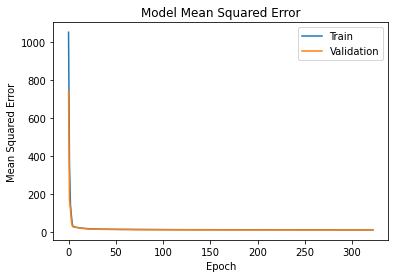

In [14]:
# print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

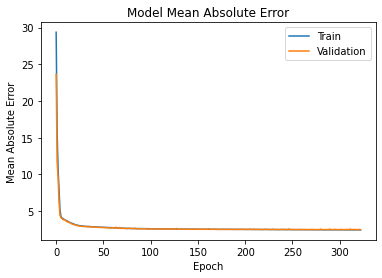

In [15]:
# print(history.history.keys())
# "Mae"
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [16]:
# pd.set_option('display.max_row', None)
display(pd.DataFrame(history.history))
# pd.set_option('display.max_row', 60)

,loss,mae,val_loss,val_mae
0,1053.687500,29.363020,740.951904,23.646608
1,357.139557,15.787886,170.134369,11.726131
2,146.735321,10.832930,119.867828,9.681828
3,89.226776,8.133863,56.483013,6.340188
4,41.337406,5.282529,31.518040,4.480222
...,...,...,...,...
318,12.234468,2.459430,12.118587,2.510116
319,12.217454,2.456419,12.046199,2.480854
320,12.212727,2.455455,12.066850,2.493162
321,12.219817,2.458429,12.205204,2.530410


In [17]:
mse_value, mae_value = model.evaluate(x_nn_val, y_nn_val, verbose=0)

In [18]:
print(mse_value)

12.175199508666992


In [19]:
print(mae_value)

2.501314640045166


## Prediction

In [20]:
# For regression
y_pred = model.predict(x_nn_val)

In [21]:
r2_score(y_nn_val, y_pred)

0.9342206180492748

## Save/Reload Models

In [22]:
model.save('best_model_file.h5')

In [23]:
model = load_model('best_model_file.h5')

# Bayesian Optimization

In [24]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=541b7e4910908aca3c104bef5f6f4cfe24af461171da8f708c920e6049a6face
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [25]:
from bayes_opt import BayesianOptimization

In [26]:
def bo_tune_xgb(colsample_bytree, learning_rate, max_depth, alpha, n_estimators):
  params = {'objective': 'reg:squarederror',
        'colsample_bytree': colsample_bytree, #0-1
        'learning_rate': learning_rate, #0-1
        'max_depth': int(max_depth), #3-10
        'alpha': int(alpha), #5-15
        'n_estimators': int(n_estimators), #100-200
        'eval_metric': 'rmse'
        }
  cv_result = xgb.cv(params, data_dmatrix, num_boost_round=100, nfold=10)
  return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [27]:
xgb_bo = BayesianOptimization(bo_tune_xgb, {'colsample_bytree': (0, 1),
                'learning_rate':(0,1),
                'max_depth': (3, 100),
                'alpha':(5,15),
                'n_estimators':(100,200)
                })

In [28]:
# xgb_bo.maximize(n_iter=10, init_points=8, acq='ei')

In [29]:
# #Extracting the best parameters
# params = xgb_bo.max['params']
# print(params)

In [30]:
params = {'alpha': 7.822901166008281, 'colsample_bytree': 0.5930972611922415, 'learning_rate': 0.12966598105968694, 'max_depth': 12.971963306519237, 'n_estimators': 141.86611158222127}

In [31]:
#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

In [32]:
xg_reg2 = xgb.XGBRegressor(**params)

In [33]:
xg_reg2.fit(x_xgb_train, y_xgb_train)

preds = xg_reg2.predict(x_xgb_val)

[12:19:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [34]:
mse = mean_squared_error(y_xgb_val, preds)
print("MSE: %f" % (mse))

MSE: 14.283351


In [35]:
import pickle
# save model to file
pickle.dump(xg_reg2, open("pima.pickle.dat", "wb"))

In [36]:
# load model from file
xg_reg2 = pickle.load(open("pima.pickle.dat", "rb"))

[12:19:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Test the model

In [37]:
test_data = pd.read_csv('test.csv')

In [38]:
# Load 2017 and 2018 Public Holiday Data

ph_data = pd.read_csv('2017_2018PublicHolidayWithoutSunday.csv')

ph_data['date'] = pd.to_datetime(ph_data['date'], format='%d/%m/%Y')

In [39]:
def dataPreparation(data):
  result = pd.DataFrame()
  result = data
  result['date'] = pd.to_datetime(result['date'], format='%d/%m/%Y %H:%M')

  # Extract Date from DateTime
  result['dateonly'] = result['date'].dt.date

  # Extract Year from DateTime
  result['year'] = result['date'].dt.year
  result = pd.get_dummies(result, columns=['year'])

  # Extract Month from DateTime
  result['month'] = result['date'].dt.month_name()
  result = pd.get_dummies(result, columns=['month'])

  # Extract Weekday (Monday to Sunday) from DateTime
  result['weekday'] = result['date'].dt.day_name()
  result = pd.get_dummies(result, columns=['weekday'])

  # Extract Weekday or Weekend from DateTime
  # result['weekend'] = ((pd.DatetimeIndex(result.date).dayofweek) // 5 == 1).astype(int)

  # Extract Time from DateTime
  result['hour'] = result['date'].dt.strftime('%H')
  result = pd.get_dummies(result, columns=['hour'])

  # The Date is Public Holiday (What is the definition? Sun? Sat?)
  holiday_dict = {}
  for index, holiday in ph_data['date'].items():
    holiday_dict[holiday] = 1

  result['holiday']= result['dateonly'].map(holiday_dict)
  result['holiday'] = result['holiday'].replace(np.nan, 0)

  # Tomorrow is Purlic Holiday
  tmrHoliday_dict = {}
  for index, holiday in ph_data['date'].items():
    tmrHoliday_dict[holiday - timedelta(days=1)] = 1

  result['tmrHoliday']= result['dateonly'].map(tmrHoliday_dict)
  result['tmrHoliday'] = result['tmrHoliday'].replace(np.nan, 0)

  # Yesterday is Purlic Holiday
  ydHoliday_dict = {}
  for index, holiday in ph_data['date'].items():
    ydHoliday_dict[holiday + timedelta(days=1)] = 1

  result['ydHoliday']= result['dateonly'].map(ydHoliday_dict)
  result['ydHoliday'] = result['ydHoliday'].replace(np.nan, 0)
  return result

In [40]:
test_data = dataPreparation(test_data)

In [41]:
def dataPrepExt(data):
  data['month_Jan_Dec'] = np.where((data['month_January'] == 1) | (data['month_December'] == 1), 1, 0)
  data['month_Mar_to_May'] = np.where((data['month_March'] == 1) | (data['month_April'] == 1) | (data['month_May'] == 1), 1, 0)
  data['month_Jul_Aug'] = np.where((data['month_July'] == 1) | (data['month_August'] == 1), 1, 0)
  data['month_Sep_to_Nov'] = np.where((data['month_September'] == 1) | (data['month_October'] == 1) | (data['month_November'] == 1), 1, 0)
  data['Sat_not_Holiday'] = np.where((data['weekday_Saturday'] == 1) & (data['holiday'] == 0), 1, 0)
  data['yd_tmr_Holiday'] = np.where(((data['ydHoliday'] == 1) | (data['tmrHoliday'] == 1)) & (data['weekday_Saturday'] == 0) & (data['weekday_Sunday'] == 0) & (data['holiday'] == 0), 1, 0)
  data['weekday'] = np.where((data['yd_tmr_Holiday'] == 0) & (data['weekday_Saturday'] == 0) & (data['weekday_Sunday'] == 0) & (data['holiday'] == 0), 1, 0)
  data['hour_02_to_06'] = np.where((data['hour_02'] == 1) | (data['hour_03'] == 1) | (data['hour_04'] == 1) | (data['hour_05'] == 1) | (data['hour_06'] == 1), 1, 0)
  data['hour_08_09'] = np.where((data['hour_08'] == 1) | (data['hour_09'] == 1), 1, 0)
  data['hour_10_11'] = np.where((data['hour_10'] == 1) | (data['hour_11'] == 1), 1, 0)
  data['hour_12_13'] = np.where((data['hour_12'] == 1) | (data['hour_13'] == 1), 1, 0)
  data['hour_15_16'] = np.where((data['hour_15'] == 1) | (data['hour_16'] == 1), 1, 0)
  data['hour_17_18'] = np.where((data['hour_17'] == 1) | (data['hour_18'] == 1), 1, 0)
  return data

In [42]:
test_data = dataPrepExt(test_data)

In [43]:
# x_test = extract_features(test_data)

x_test = test_data.drop(useless1_test, axis=1)

In [44]:
x_test["year_2017"] = 0

In [45]:
cols = x_test.columns.tolist()
cols = cols[-1:] + cols[:-1]
x_test = x_test[cols]

In [46]:
x_nn_test = sm.add_constant(x_test, prepend=True, has_constant='add')

In [47]:
x_test.shape

(3504, 48)

In [48]:
x_nn_test = scaler.transform(x_nn_test)
pred_y_nn_test = model.predict(x_nn_test)

In [49]:
pred_y_test = xg_reg2.predict(x_test)

In [50]:
pred_y_combine = np.mean([pred_y_nn_test.flatten(),pred_y_test], axis=0)

In [51]:
pred_y_combine.shape

(3504,)

In [52]:
submission = pd.DataFrame(pred_y_combine, columns=["speed"])

In [53]:
submission['id'] = np.arange(len(submission))
cols = submission.columns.tolist()
cols = cols[-1:] + cols[:-1]
submission = submission[cols]

In [54]:
submission

,id,speed
0,0,48.192757
1,1,47.198990
2,2,37.034622
3,3,28.789804
4,4,39.540894
...,...,...
3499,3499,17.680283
3500,3500,28.379429
3501,3501,46.351440
3502,3502,40.689316


In [55]:
submission.to_csv("Submission.csv", index=False)
# limit lowerbound and upperbound
# use 2017 to train and 2018 to val